In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist


In [2]:
# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # Reshape to (batch, height, width, channels)
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
latent_dim = 2  # Dimension of the latent space

# Define the encoder
encoder_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Latent variables
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)


In [4]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [5]:
# Latent space sampling
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)


In [6]:
# Define VAE model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoder_output, name='decoder')

# VAE model
vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name='vae')


In [7]:
# Define loss function
reconstruction_loss = tf.keras.losses.binary_crossentropy(tf.keras.backend.flatten(encoder_input), tf.keras.backend.flatten(vae_output))
reconstruction_loss *= 28 * 28
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)


ValueError: A KerasTensor cannot be used as input to a TensorFlow function. A KerasTensor is a symbolic placeholder for a shape and dtype, used when constructing Keras Functional models or Keras Functions. You can only use it as input to a Keras layer or a Keras operation (from the namespaces `keras.layers` and `keras.operations`). You are likely doing something like:

```
x = Input(...)
...
tf_fn(x)  # Invalid.
```

What you should do instead is wrap `tf_fn` in a layer:

```
class MyLayer(Layer):
    def call(self, x):
        return tf_fn(x)

x = MyLayer()(x)
```


In [ ]:
# Compile model
vae.compile(optimizer='adam')

# Train model
vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test, None))


In [ ]:
# Visualize latent space
def plot_latent_space(encoder, x_test, n=30, figsize=15):
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=figsize)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space")
    plt.show()

plot_latent_space(encoder, x_test)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.datasets import mnist

# Load MNIST dataset
(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # Reshape to (batch, height, width, channels)
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

latent_dim = 2  # Dimension of the latent space

# Define the encoder
encoder_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Latent variables
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Latent space sampling
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Define VAE model
encoder = Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = Model(decoder_input, decoder_output, name='decoder')

# VAE model input
vae_output = decoder(encoder(encoder_input)[2])
vae = Model(encoder_input, vae_output, name='vae')

# Define loss layer
class VAELoss(tf.keras.layers.Layer):
    def call(self, inputs):
        encoder_input, vae_output, z_mean, z_log_var = inputs

        # Compute the reconstruction loss
        reconstruction_loss = tf.keras.losses.binary_crossentropy(
            tf.keras.backend.flatten(encoder_input),
            tf.keras.backend.flatten(vae_output)
        )
        reconstruction_loss *= 28 * 28

        # Compute KL divergence
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        return tf.reduce_mean(reconstruction_loss + kl_loss)

# Add the custom loss layer
vae_loss_layer = VAELoss()
vae.add_loss(vae_loss_layer([encoder_input, vae_output, z_mean, z_log_var]))

# Compile model
vae.compile(optimizer='adam')

# Train model
vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test, None))

# Visualize latent space
def plot_latent_space(encoder, x_test, n=30, figsize=15):
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=figsize)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space")
    plt.show()

plot_latent_space(encoder, x_test)


NotImplementedError: 

Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 257.1738 - val_loss: 172.1603
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 168.0064 - val_loss: 160.6790
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 160.1659 - val_loss: 158.2397
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 157.5618 - val_loss: 156.5878
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 156.0675 - val_loss: 154.8919
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 155.0779 - val_loss: 154.3116
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 153.5249 - val_loss: 153.3689
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 153.0462 - val_loss: 152.6808
Epoch 9/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 152.3267 - val_loss: 152.6727
Epoch 10/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 151.8937 - val_loss: 151.9321
Epoch 11/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 151.4117 - val_loss: 151.5609
Epoch 

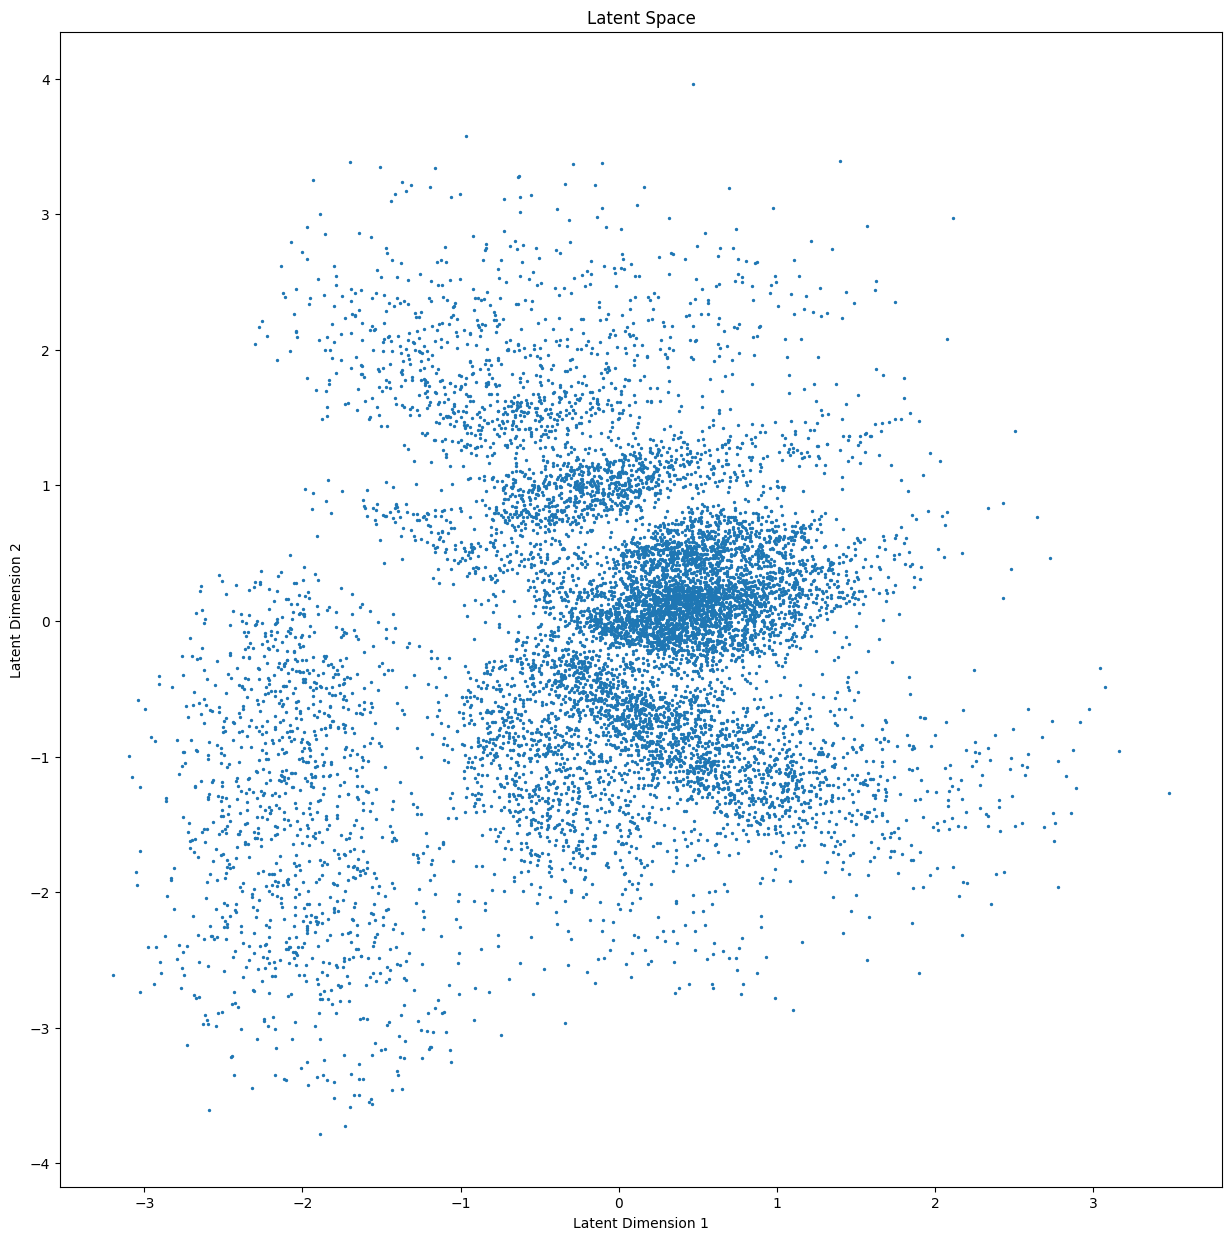

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


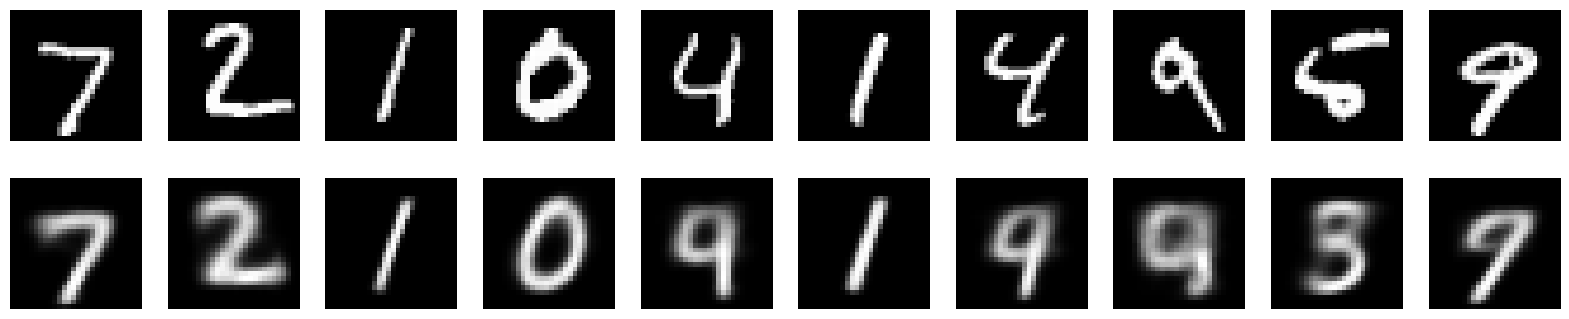

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

# Load the MNIST dataset
(x_train, _), (x_test, _) = tf.keras.datasets.mnist.load_data()
x_train = np.reshape(x_train, (-1, 28, 28, 1)).astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1)).astype("float32") / 255.0

# Set latent dimension
latent_dim = 2

# Define the Encoder
encoder_input = layers.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation='relu', padding='same')(encoder_input)
x = layers.MaxPooling2D()(x)
x = layers.Conv2D(64, 3, activation='relu', padding='same')(x)
x = layers.MaxPooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation='relu')(x)

# Latent variables
z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Latent space sampling
z = layers.Lambda(sampling)([z_mean, z_log_var])

# Define the Decoder
decoder_input = layers.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation='relu')(decoder_input)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', padding='same')(x)
x = layers.UpSampling2D()(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation='sigmoid', padding='same')(x)

# Create encoder and decoder models
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name='encoder')
decoder = models.Model(decoder_input, decoder_output, name='decoder')

# Define the VAE model
class VAE(tf.keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)

        # Compute the reconstruction loss
        reconstruction_loss = tf.keras.losses.binary_crossentropy(
            tf.keras.backend.flatten(inputs),
            tf.keras.backend.flatten(reconstructed)
        )
        reconstruction_loss *= 28 * 28

        # Compute KL divergence
        kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
        kl_loss = tf.reduce_sum(kl_loss, axis=-1)
        kl_loss *= -0.5

        # Total loss
        total_loss = tf.reduce_mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)

        return reconstructed

# Create VAE model
vae = VAE(encoder, decoder)

# Compile model
vae.compile(optimizer='adam')

# Train model
vae.fit(x_train, epochs=30, batch_size=128, validation_data=(x_test, None))

# Visualize latent space
def plot_latent_space(encoder, x_test, n=30, figsize=(15, 15)): # Changed figsize to a tuple
    z_mean, _, _ = encoder.predict(x_test)
    plt.figure(figsize=figsize)
    plt.scatter(z_mean[:, 0], z_mean[:, 1], s=2)
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Latent Dimension 2")
    plt.title("Latent Space")
    plt.show()

plot_latent_space(encoder, x_test)

# Function to display reconstructed images
def display_reconstructed_images(vae, x_test, n=10):
    reconstructed_images = vae.predict(x_test[:n])

    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

        # Display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed_images[i].reshape(28, 28), cmap="gray")
        plt.axis("off")

    plt.show()

# Display some original and reconstructed images
display_reconstructed_images(vae, x_test)


Explanation of the Code

1. Data Loading: The MNIST dataset is loaded and preprocessed to normalize the pixel values.

2. Encoder Definition: The encoder consists of convolutional layers to extract features and produce two latent variables, z_mean and z_log_var.

3. Latent Sampling: A custom sampling function generates latent samples using the reparameterization trick.

4. Decoder Definition: The decoder reconstructs the images from the latent variables using transposed convolutional layers.

5. VAE Model Class: A custom VAE class computes the reconstruction and KL divergence losses during the forward pass.

6. Training: The VAE model is compiled and trained on the MNIST dataset.

7. Latent Space Visualization: A function to plot the latent space using the learned z_mean values.

8. Image Reconstruction Visualization: A function to display original and reconstructed images.